<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetection/blob/KNN_LOF/KNN_LOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Any NaN values in features: False


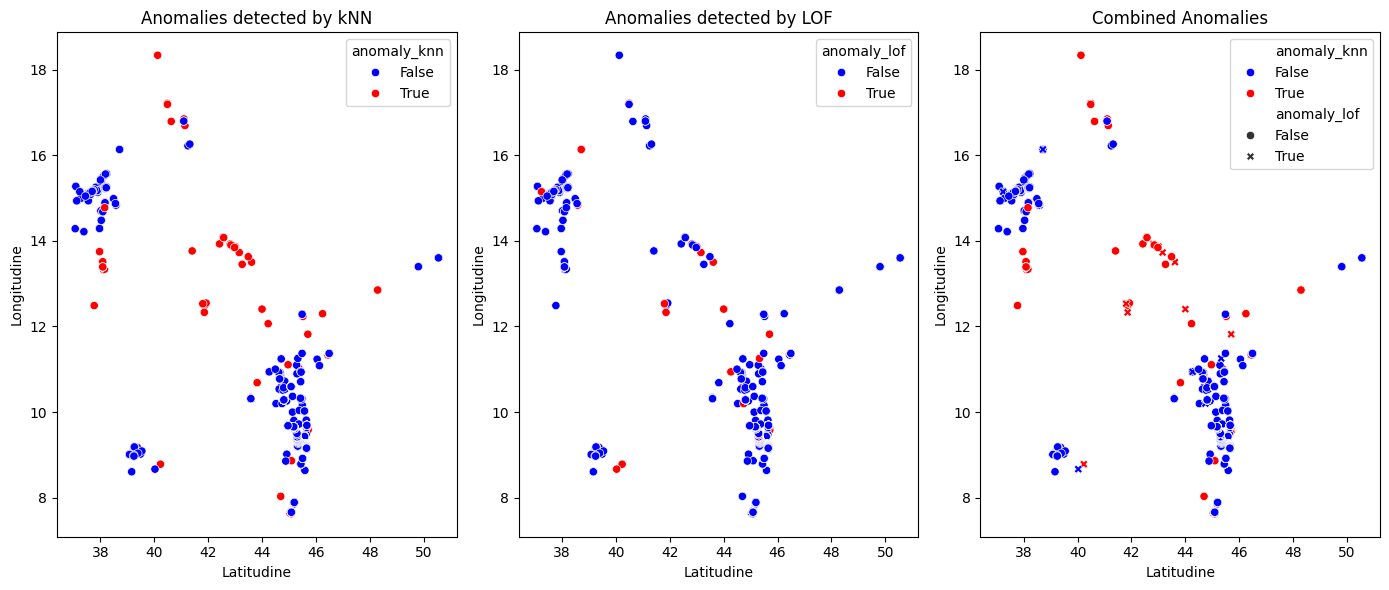

,idAnomalia,idConcentratore,dataAnomalia,latitudine,longitudine,dataCoordinate,dataSegnalazione,note,idPunto,anomaly_knn,anomaly_lof
0,18526375,SR013287,2023-05-26 12:16:28,39.2512,9.1338,2023-05-26 12:16:28,2015-04-22 14:24:01.353,-1.0,-1.0,True,True
1,18699686,SR013287,2023-01-11 13:46:47,39.2585,9.0723,2023-01-11 13:46:47,2015-06-27 09:05:07.203,-1.0,45267.0,True,True
2,19367851,SR013279,2022-10-10 08:42:46,40.1240,18.3356,2022-10-10 08:42:46,2015-10-12 09:07:23.653,-1.0,42607.0,True,False
4,21076623,SR010385,2022-03-28 06:58:52,44.2287,12.0657,2022-03-28 06:58:52,2016-04-18 07:13:12.357,-1.0,-1.0,True,False
6,21702052,SR013279,2022-02-04 05:12:16,40.6294,16.7904,2022-02-04 05:12:16,2016-06-17 06:18:30.337,-1.0,6556.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1225,35923193,SR013001,2021-01-03 13:26:35,38.7120,16.1350,2021-01-03 13:26:35,2021-01-04 02:28:53.940,6.0,2929.0,False,True
1231,35923202,LOM1916,2021-01-04 01:51:48,48.2926,12.8515,2021-01-04 01:51:48,2021-01-04 02:30:21.643,4.0,331986.0,True,False
1232,35923203,LOM1916,2021-01-04 01:51:49,48.2926,12.8515,2021-01-04 01:51:49,2021-01-04 02:30:31.680,4.0,331986.0,True,False
1233,35923204,LOM1916,2021-01-04 01:51:46,48.2926,12.8515,2021-01-04 01:51:46,2021-01-04 02:30:40.700,4.0,331986.0,True,False


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Load the data
file_path = 'Anomalies_2021_2024.xlsx'
data = pd.read_excel(file_path)

# Preprocessing
# Convert 'latitudine' and 'longitudine' to numeric by replacing commas
data['latitudine'] = data['latitudine'].str.replace(',', '.').astype(float)
data['longitudine'] = data['longitudine'].str.replace(',', '.').astype(float)

# Fill missing values in 'idPunto' with a specific value or drop them based on the context
data['idPunto'] = data['idPunto'].fillna(-1)  # Using -1 to denote missing points

# Ensure 'note' is numeric and fill missing values with a placeholder (e.g., -1)
data['note'] = pd.to_numeric(data['note'], errors='coerce').fillna(-1)

# Select relevant features
features = data[['latitudine', 'longitudine', 'note', 'idPunto']].copy()

# Check for any remaining NaN values
print("Any NaN values in features:", features.isnull().values.any())

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Detect anomalies using kNN
# Fit the model
k = 5  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(features_scaled)

# Calculate the distance to the k-th nearest neighbor
distances, indices = nbrs.kneighbors(features_scaled)
k_distances = distances[:, -1]

# Set a threshold for anomaly detection
threshold = np.percentile(k_distances, 95)  # Top 5% distances
anomalies_knn = k_distances > threshold

# Detect anomalies using LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
anomalies_lof = lof.fit_predict(features_scaled)
anomalies_lof = anomalies_lof == -1  # -1 indicates anomaly

# Create a dataframe to store results
results = data.copy()
results['anomaly_knn'] = anomalies_knn
results['anomaly_lof'] = anomalies_lof

# Filter rows where anomalies are detected
anomalies_detected = results[(results['anomaly_knn']) | (results['anomaly_lof'])]

# Plotting
plt.figure(figsize=(14, 6))

# Plot the original data points
plt.subplot(1, 3, 1)
sns.scatterplot(data=results, x='latitudine', y='longitudine', hue='anomaly_knn', palette={True: 'red', False: 'blue'})
plt.title('Anomalies detected by kNN')
plt.xlabel('Latitudine')
plt.ylabel('Longitudine')

# Plot anomalies detected by LOF
plt.subplot(1, 3, 2)
sns.scatterplot(data=results, x='latitudine', y='longitudine', hue='anomaly_lof', palette={True: 'red', False: 'blue'})
plt.title('Anomalies detected by LOF')
plt.xlabel('Latitudine')
plt.ylabel('Longitudine')

# Combined plot
plt.subplot(1, 3, 3)
sns.scatterplot(data=results, x='latitudine', y='longitudine', hue='anomaly_knn', style='anomaly_lof', palette={True: 'red', False: 'blue'}, markers={True: 'X', False: 'o'})
plt.title('Combined Anomalies')
plt.xlabel('Latitudine')
plt.ylabel('Longitudine')

plt.tight_layout()
plt.show()

# Display the anomalies detected
anomalies_detected
